In [0]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [0]:
import gzip
import pickle
import sys
from copy import deepcopy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class BayesLinear(nn.Module):
  
  def __init__(self, input_size, output_size):
    super(BayesLinear, self).__init__()
    
    self.inp = input_size
    self.out = output_size
    
    self.w_mu = nn.Parameter(torch.zeros(self.out, self.inp))
    self.w_var = nn.Parameter(1e-6 * torch.ones(self.out, self.inp))
    self.w = torch.distributions.Normal(self.w_mu, self.w_var)
    
    self.w_prior_mu = torch.Tensor([0.]).to(device)
    self.w_prior_var = torch.Tensor([1.]).to(device)    
    
  def forward(self, x, sample=False, calculate_log_probs=False):
    
    if self.training or sample:
      w = self.w.sample()
    else:
      w = self.mean
    
    return F.linear(x, w)
  
  def kl(self):
    
    return (torch.log(torch.sqrt(self.w_prior_var)) - torch.log(torch.sqrt(self.w_var)) + (
            (self.w_mu - self.w_prior_mu) ** 2 + self.w_var - self.w_prior_var) / (
            2. * self.w_prior_var)).sum()
        

In [0]:
class new_VCL(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(new_VCL, self).__init__()
    
    self.inp = input_size
    self.hid = hidden_size
    self.out = output_size
    
    self.bfc1 = BayesLinear(self.inp, self.hid)
    self.bfc2 = BayesLinear(self.hid, self.hid)
    self.bfc3 = BayesLinear(self.hid, self.out)
    
    self.relu = nn.ReLU()
    
  def forward(self, x):
    
    x = self.relu(self.bfc1(x))
    x = self.relu(self.bfc2(x))
    out = self.bfc3(x)
    
    return out
  
  def logpred(self, predictions, targets):
    
#     print(predictions.shape)
#     print(targets.shape)
    log_lik = - torch.mean(F.binary_cross_entropy_with_logits(input=predictions, target=targets))
    
    return log_lik
  
  def kl_calc(self):
    
    return self.bfc1.kl() + self.bfc2.kl() + self.bfc3.kl()
  
  def train(self, x, y, batch_size, n_epochs, task_id, display_epoch=20):
  
    print('Task is:', task_id)
    optim = torch.optim.Adam(self.parameters(), lr=0.001)
    N = x.shape[0]
    if batch_size > N:
      batch_size = N

    costs = []

    for epoch in range(n_epochs):

      perm_inds = list(range(x.shape[0]))
      np.random.shuffle(perm_inds)
      cur_x = x[perm_inds]
      cur_y = y[perm_inds]

      avg_cost = 0.
      total_batch = int(np.ceil(N * 1.0 / batch_size))
      
      for i in range(total_batch):

        start_ind = i*batch_size
        end_ind = np.min([(i+1)*batch_size, N])
        batch_x = cur_x[start_ind:end_ind, :]
        batch_y = cur_y[start_ind:end_ind, :]
        
        batch_x = Variable(torch.from_numpy(batch_x)).to(device)
        batch_y = Variable(torch.from_numpy(batch_y)).to(device)

        optim.zero_grad()   
        outputs = self.forward(batch_x) 
        log_pred = self.logpred(outputs, batch_y) 
        kl = self.kl_calc()
        loss = kl - log_pred
        loss.backward()
        optim.step()

        avg_cost += loss.item() / total_batch

      if epoch % display_epoch == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost =", \
                "{:.9f}".format(avg_cost))

      costs.append(avg_cost)

    print("Optimization Finished!")

    return costs  
  

In [0]:
def run_vcl(hidden_size, no_epochs, data_gen, coreset_method, coreset_size=0, batch_size=None, single_head=True):
  
  in_dim, out_dim = data_gen.get_dims()
  x_coresets, y_coresets = [], []
  x_testsets, y_testsets = [], []
  
  all_acc = np.array([])
  
  for task_id in range(data_gen.max_iter):
    
    x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)
    
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    if task_id == 0:
      
      ml_model = new_VCL(in_dim, hidden_size, output_size=10).to(device)  
      ml_model.train(x_train, y_train, bsize, no_epochs, task_id)
      torch.save(ml_model.state_dict(), 'my_model.pth')
    
    else: 
    
      ml_model = new_VCL(in_dim, hidden_size, output_size=10).to(device)
      ml_model.load_state_dict(torch.load('my_model.pth'))
      ml_model.train(x_train, y_train, bsize, no_epochs, task_id)
      torch.save(ml_model.state_dict(), 'my_model.pth')
    
    if coreset_size > 0:
      x_coresets, y_coresets, x_train, y_train = coreset_method(x_coresets, y_coresets, x_train, y_train, coreset_size)
    
    acc = get_scores(ml_model, x_testsets, y_testsets, x_coresets, y_coresets, hidden_size, no_epochs, single_head, batch_size)
    all_acc = concatenate_results(acc, all_acc)
    
  return all_acc



In [0]:
def merge_coresets(x_coresets, y_coresets):
  
    merged_x, merged_y = x_coresets[0], y_coresets[0]
    for i in range(1, len(x_coresets)):
        merged_x = np.vstack((merged_x, x_coresets[i]))
        merged_y = np.vstack((merged_y, y_coresets[i]))
        
    return merged_x, merged_y

def get_scores(model, x_testsets, y_testsets, x_coresets, y_coresets, hidden_size, no_epochs, single_head, batch_size=None):
  
    acc = []

    if single_head:
        if len(x_coresets) > 0:
            x_train, y_train = merge_coresets(x_coresets, y_coresets)
            bsize = x_train.shape[0] if (batch_size is None) else batch_size
            final_model = new_VCL(x_train.shape[1], hidden_size, y_train.shape[1]).to(device)
            final_model.train(x_train, y_train, bsize, no_epochs, task_id=0)
        else:
            final_model = model

    for i in range(len(x_testsets)):
        if not single_head:
            if len(x_coresets) > 0:
                x_train, y_train = x_coresets[i], y_coresets[i]
                bsize = x_train.shape[0] if (batch_size is None) else batch_size
                final_model = new_VCL(x_train.shape[1], hidden_size, y_train.shape[1]).to(device)
                final_model.train(x_train, y_train, bsize, no_epochs, task_id=i)
            else:
                final_model = model

        head = 0 if single_head else i
        x_test, y_test = x_testsets[i], y_testsets[i]
        
        x_test = Variable(torch.from_numpy(x_test)).to(device)
#         y_test = Variable(torch.from_numpy(y_test))
        
        pred = final_model.forward(x_test)
        pred_mean = np.mean(pred.detach().cpu().numpy(), axis=0)
        pred_y = np.argmax(pred_mean)
        y = np.argmax(y_test, axis=1)
        cur_acc = len(np.where((pred_y - y) == 0)[0]) * 1.0 / y.shape[0]
        acc.append(cur_acc)
        
    return acc

def concatenate_results(score, all_score):
  
    if all_score.size == 0:
        all_score = np.reshape(score, (1,-1))
    else:
        new_arr = np.empty((all_score.shape[0], all_score.shape[1]+1))
        new_arr[:] = np.nan
        new_arr[:,:-1] = all_score
        all_score = np.vstack((new_arr, score))
        
    return all_score

def plot(vcl, rand_vcl):
  
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    plt.figure(figsize=(7,3))
#     ax = plt.gca()
    plt.plot(np.arange(len(vcl))+1, vcl, label='VCL', marker='o')
    plt.plot(np.arange(len(rand_vcl))+1, rand_vcl, label='VCL + Random Coreset', marker='o')
#     plt.plot(np.arange(len(kcen_vcl))+1, kcen_vcl, label='VCL + K-center Coreset', marker='o')
    plt.xticks(range(1, len(vcl)+1))
    plt.ylabel('Average accuracy')
    plt.xlabel('# tasks')
    plt.legend()

#     fig.savefig(filename, bbox_inches='tight')
    plt.show()

In [0]:
""" Random coreset selection """
def rand_from_batch(x_coreset, y_coreset, x_train, y_train, coreset_size):
  
    # Randomly select from (x_train, y_train) and add to current coreset (x_coreset, y_coreset)
    idx = np.random.choice(x_train.shape[0], coreset_size, False)
    x_coreset.append(x_train[idx,:])
    y_coreset.append(y_train[idx,:])
    x_train = np.delete(x_train, idx, axis=0)
    y_train = np.delete(y_train, idx, axis=0)
    
    return x_coreset, y_coreset, x_train, y_train    

""" K-center coreset selection """
def k_center(x_coreset, y_coreset, x_train, y_train, coreset_size):
  
    # Select K centers from (x_train, y_train) and add to current coreset (x_coreset, y_coreset)
    dists = np.full(x_train.shape[0], np.inf)
    current_id = 0
    dists = update_distance(dists, x_train, current_id)
    idx = [ current_id ]

    for i in range(1, coreset_size):
        current_id = np.argmax(dists)
        dists = update_distance(dists, x_train, current_id)
        idx.append(current_id)

    x_coreset.append(x_train[idx,:])
    y_coreset.append(y_train[idx,:])
    x_train = np.delete(x_train, idx, axis=0)
    y_train = np.delete(y_train, idx, axis=0)

    return x_coreset, y_coreset, x_train, y_train

def update_distance(dists, x_train, current_id):
  
    for i in range(x_train.shape[0]):
        current_dist = np.linalg.norm(x_train[i,:]-x_train[current_id,:])
        dists[i] = np.minimum(current_dist, dists[i])
        
    return dists

Task is: 0
Epoch: 0001 cost = 186728.388094275
Epoch: 0021 cost = 106721.626398216
Epoch: 0041 cost = 56722.987230728
Epoch: 0061 cost = 18421.995641027
Epoch: 0081 cost = 1153.494779972
Optimization Finished!
Task is: 1
Epoch: 0001 cost = 180.006306703
Epoch: 0021 cost = 180.341844005
Epoch: 0041 cost = 178.727828164
Epoch: 0061 cost = 176.008049197
Epoch: 0081 cost = 182.663743302
Optimization Finished!
Task is: 2
Epoch: 0001 cost = 178.780501588
Epoch: 0021 cost = 174.137022700
Epoch: 0041 cost = 177.933424480
Epoch: 0061 cost = 179.278345676
Epoch: 0081 cost = 179.444549945
Optimization Finished!
Task is: 3
Epoch: 0001 cost = 186.366629382
Epoch: 0021 cost = 182.278499448
Epoch: 0041 cost = 181.450843067
Epoch: 0061 cost = 182.451976932
Epoch: 0081 cost = 185.470583432
Optimization Finished!
Task is: 4
Epoch: 0001 cost = 172.037692618
Epoch: 0021 cost = 178.856386364
Epoch: 0041 cost = 182.895792791
Epoch: 0061 cost = 173.504303017
Epoch: 0081 cost = 178.803512381
Optimization Fini

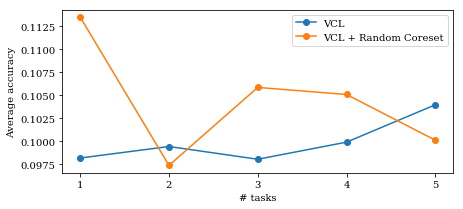

In [12]:
class PermutedMnistGenerator():
  def __init__(self, max_iter=10):

    f = gzip.open('/content/drive/My Drive/mnist.pkl.gz', 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    f.close()

    self.X_train = np.vstack((train_set[0], valid_set[0]))
    self.Y_train = np.hstack((train_set[1], valid_set[1]))
    self.X_test = test_set[0]
    self.Y_test = test_set[1]
    self.max_iter = max_iter
    self.cur_iter = 0

  def get_dims(self):

    return self.X_train.shape[1], 10

  def next_task(self):

    if self.cur_iter >= self.max_iter:
        raise Exception('Number of tasks exceeded!')
    else:
        np.random.seed(self.cur_iter)
        perm_inds = list(range(self.X_train.shape[1])) #
        np.random.shuffle(perm_inds)

        # Retrieve train data
        next_x_train = deepcopy(self.X_train)
        next_x_train = next_x_train[:,perm_inds]
        next_y_train = np.eye(10)[self.Y_train]

        # Retrieve test data
        next_x_test = deepcopy(self.X_test)
        next_x_test = next_x_test[:,perm_inds]
        next_y_test = np.eye(10)[self.Y_test]

        self.cur_iter += 1

        return next_x_train, next_y_train, next_x_test, next_y_test

hidden_size = 100
batch_size = 256
no_epochs = 100
single_head = True
num_tasks = 5

# Run vanilla VCL
np.random.seed(1)

coreset_size = 0
data_gen = PermutedMnistGenerator(num_tasks)
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
    rand_from_batch, coreset_size, batch_size, single_head)
print('Simple VCL', vcl_result)

# Run random coreset VCL
np.random.seed(1)

coreset_size = 200
data_gen = PermutedMnistGenerator(num_tasks)
rand_vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
    rand_from_batch, coreset_size, batch_size, single_head)
print('Random coreset VCL', rand_vcl_result)

# Run k-center coreset VCL
# np.random.seed(1)

# data_gen = PermutedMnistGenerator(num_tasks)
# kcen_vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
#     k_center, coreset_size, batch_size, single_head)
# print('k-center coreset VCL', kcen_vcl_result)

# Plot average accuracy
vcl_avg = np.nanmean(vcl_result, 1)
rand_vcl_avg = np.nanmean(rand_vcl_result, 1)
# kcen_vcl_avg = np.nanmean(kcen_vcl_result, 1)
plot(vcl_avg, rand_vcl_avg)